# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps

Load libraries and data

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# modify to where you store your project data including utils
datadir = "/content/drive/MyDrive/Colab Notebooks/CS445 Computational Photography/4_HDR_IBL/"

utilfn = datadir + "utils"
!cp -r "$utilfn" .
#samplesfn = datadir + "samples"
samplesfn = datadir + "images"
!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



mkdir: cannot create directory ‘images’: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [4]:
# TODO: Replace this with your path and files

# imdir = 'samples'
# imfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
# exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]
imdir = 'images'
imfns = ['0030.jpg', '0040.jpg', '0060.jpg', '0120.jpg','0210.jpg','0442.jpg']
exposure_times = [1/30.0, 1/40.0, 1/60.0, 1/120.0, 1/210.0, 1/442.0]

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)



In [5]:
# checking ranges
print(f"LDR images initial range: min={ldr_images.min():.3f}, max={ldr_images.max():.3f}")

# histo per image (to see if under or over exposed)
for i in range(len(ldr_images)):
    hist, _ = np.histogram(ldr_images[i].flatten(), bins=20, range=(0, 1))
    print(f"\nImage {i} histogram: {hist}")
    print(f"Image {i} range: min={ldr_images[i].min():.3f}, max={ldr_images[i].max():.3f}")

LDR images initial range: min=0.000, max=1.000

Image 0 histogram: [  19555   11314   19268   45496  113001  100936   97847   73333   77210
   75144   80189   74155   75846   82090   84635   73296   75658   79273
   88064 2127018]
Image 0 range: min=0.000, max=1.000

Image 1 histogram: [ 24549  25800  96799 115910 123810 107678 103967 108037 139368 149329
 180949 181863 186117 185168 189257 151861 175181 168359  95210 964116]
Image 1 range: min=0.000, max=1.000

Image 2 histogram: [124138 193370 174708 152522 185451 242355 290321 299671 364562 361673
 276098 198044 178300 138618  94507  58293  43539  27117  16961  53080]
Image 2 range: min=0.000, max=1.000

Image 3 histogram: [ 83941 246493 212177 183346 216779 278927 321998 295133 378653 344974
 273654 172305 150411  89459  62187  42770  35066  24749  14319  45987]
Image 3 range: min=0.000, max=1.000

Image 4 histogram: [512248 333118 368129 426011 449992 452944 338950 174690 106228  55195
  45601  38785  35690  29982  23057  17678  1

### Utility Functions

In [6]:
EPSILON = 1e-6

def compute_weight_smooth(z_float): # [0,1]
    """ Gaussian distribution (μ=0.5, σ=0.25) for smoother interpolation """
    return np.exp(-4 * ((z_float - 0.5) ** 2))

def compute_weight_linear(z_int): # [0,255]
    return 128 - np.abs(z_int - 128)

def get_normalized_ball_coords(h, w, margin=0):
    """
    Creates normalized coordinate system for mirror ball with center at image center.

    Args:
        h: Image height
        w: Image width
        margin: Optional margin to shrink the valid area (in pixels)

    Returns:
        tuple containing:
            X_norm: Normalized x-coordinates in [-1,1] range
            Y_norm: Normalized y-coordinates in [-1,1] range
            valid_mask: Boolean mask for pixels inside the mirror ball
    """
    x = np.arange(w)
    y = np.arange(h)
    X, Y = np.meshgrid(x, y)

    center_x, center_y = w // 2, h // 2
    radius = min(h, w) // 2 - margin

    X_norm = (X - center_x) / radius
    Y_norm = (Y - center_y) / radius

    R_sq = X_norm**2 + Y_norm**2

    valid_mask = R_sq <= 1.0

    return X_norm, Y_norm, valid_mask


def create_weight_array():
    """(LUT) create an array of weights for all possible pixel values (0-255)"""
    weight_array = np.zeros(256, dtype=np.float32)
    for z in range(256):
        weight_array[z] = compute_weight_linear(z)
    return weight_array

### Naive LDR merging

Compute the HDR image as average of irradiance estimates from LDR images

In [7]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.

    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.

    2) Return average of above images


    For further explanation, please refer to problem page for how to do it.

    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures

    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)

    # Initialize irradiance accumulator and log irradiance array
    irradiance_accum = np.zeros((H, W, C), dtype=np.float32)
    log_irradiances = np.zeros((N, H, W, C), dtype=np.float32)

    for i in range(N):
        irradiance_curr_pixel = (ldr_images[i] + EPSILON) / exposures[i]
        irradiance_accum += irradiance_curr_pixel

        log_irradiances[i] = np.log(irradiance_curr_pixel + EPSILON)

    hdr_image = irradiance_accum / N

    return hdr_image, log_irradiances

In [8]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays.
    Three suggestions to try:
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example)
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package
    '''
    """
    # METHOD 1 : log and linearly map to 0 to 1 range
    # Log normalize HDR image
    log_im_hdr = np.log(im_hdr + EPSILON)
    log_m,log_M = log_im_hdr.min(), log_im_hdr.max()
    log_normalized_hdr = (log_im_hdr - log_m) / (log_M-log_m)

    #   plot
    plt.figure(figsize=(5, 5))
    plt.imshow(log_normalized_hdr)
    plt.axis('off')
    plt.show()

    return log_normalized_hdr
    """

    plt.figure(figsize=(6, 3))

    # 1. Log normalization
    log_im_hdr = np.log(im_hdr + EPSILON)
    log_m, log_M = log_im_hdr.min(), log_im_hdr.max()
    log_normalized_hdr = (log_im_hdr - log_m) / (log_M-log_m)

    plt.subplot(1, 2, 1)
    plt.imshow(log_normalized_hdr)
    plt.title('Log Normalization')
    plt.axis('off')

    # 2. OpenCV Drago
    hdr_copy = im_hdr.copy().astype(np.float32)
    hdr_copy = np.nan_to_num(hdr_copy, nan=0, posinf=np.finfo(np.float32).max, neginf=0)

    tonemapper = cv2.createTonemapDrago(gamma=1.0, saturation=0.7)
    tonemapped = tonemapper.process(hdr_copy)

    plt.subplot(1, 2, 2)
    plt.imshow(tonemapped)
    plt.title('OpenCV Drago')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return tonemapped



HDR Image


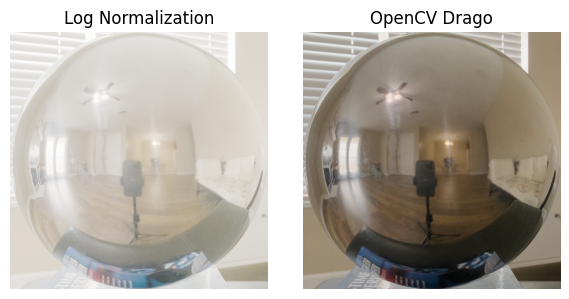

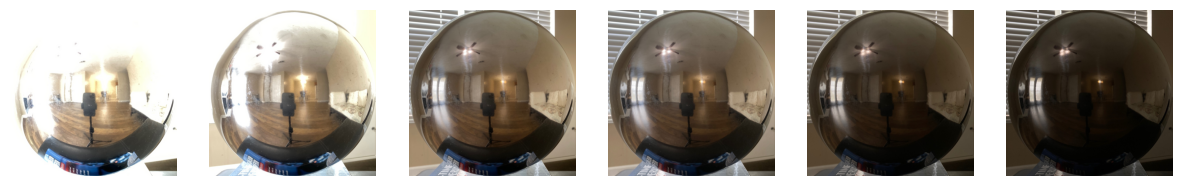

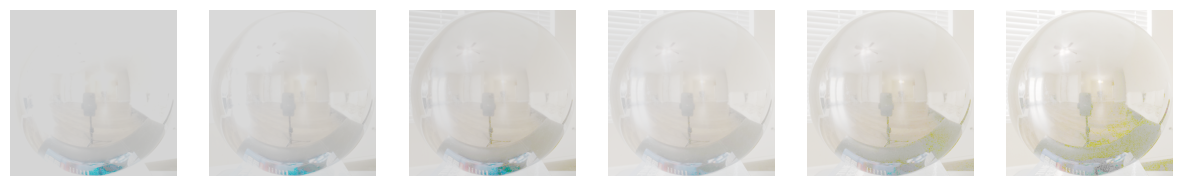

In [9]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


### Weighted LDR merging

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [10]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> np.ndarray:
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.

    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.

    3) Return weighted average of above images

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)

    irradiance_accum = np.zeros((H, W, C), dtype=np.float32)
    weight_accum = np.zeros((H, W, C), dtype=np.float32)

    for i in range(N):
        #print(ldr_images[i])
        weight = compute_weight_smooth(ldr_images[i])
        #print(weight)

        irradiance_curr = ldr_images[i] / exposure_times[i]
        #print(irradiance_curr)

        irradiance_accum += weight * irradiance_curr
        weight_accum += weight

    hdr_image = np.where(weight_accum > 0, irradiance_accum/weight_accum, 0)

    #(optional)
    # hdr_image = np.maximum(hdr_image, 0)

    if np.any(np.isnan(hdr_image)) or np.any(np.isinf(hdr_image)):
        print("Invalid intensity in HDR image")

    return hdr_image

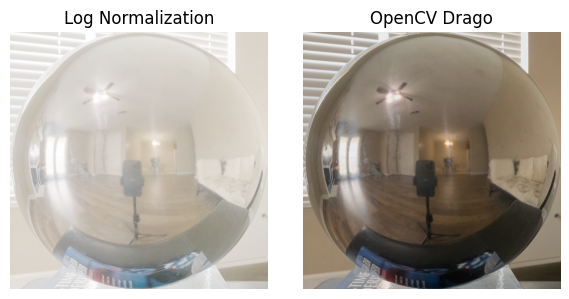

array([[[0.6373852 , 0.61463934, 0.5790243 ],
        [0.6415291 , 0.61897886, 0.58333653],
        [0.6471881 , 0.62475127, 0.5891244 ],
        ...,
        [0.59435016, 0.5075636 , 0.4024142 ],
        [0.5922397 , 0.5054873 , 0.40040553],
        [0.5922397 , 0.5054873 , 0.40040553]],

       [[0.6550174 , 0.6319316 , 0.6130393 ],
        [0.6296641 , 0.61001414, 0.5840041 ],
        [0.61718327, 0.5937516 , 0.5749499 ],
        ...,
        [0.5945799 , 0.5077078 , 0.40257198],
        [0.5924681 , 0.50562966, 0.40056083],
        [0.5924681 , 0.50562966, 0.40056083]],

       [[0.83436835, 0.81999844, 0.8186795 ],
        [0.80441856, 0.7894734 , 0.7835546 ],
        [0.7720776 , 0.75537187, 0.7521077 ],
        ...,
        [0.5929566 , 0.5058963 , 0.40072978],
        [0.59376264, 0.5068764 , 0.40164346],
        [0.59376264, 0.5068764 , 0.40164346]],

       ...,

       [[0.6805714 , 0.63247514, 0.57833606],
        [0.6781826 , 0.6302069 , 0.5762416 ],
        [0.6776538 , 0

In [11]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)


Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.92055476   Max ratio =  1.5576532


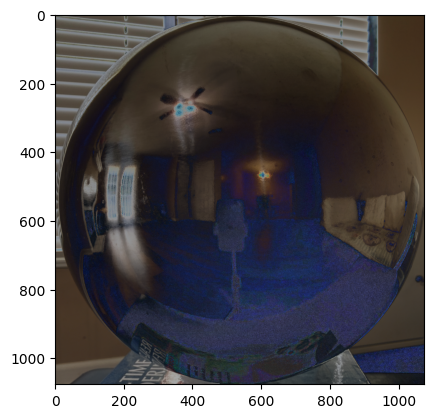

In [12]:
# display difference between naive and weighted

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [13]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm, num_samples = 1000)-> (np.ndarray, np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.

    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values


    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)

    # 1. preprocessing------------------------------------------------------
    log_exposure_times = np.log(exposure_times)

    #        bool                  indices
    # e.g., [T,F,F, T,T, F.. ] -> [0,3,4, ...]
    _, _, mirror_mask = get_normalized_ball_coords(H, W, margin=5)
    mirror_pixels = np.where(mirror_mask)

    num_samples = min(num_samples, len(mirror_pixels[0])) # Safety check
    sample_idx = np.random.choice(len(mirror_pixels[0]), num_samples, replace=False)
    sample_y, sample_x = mirror_pixels[0][sample_idx], mirror_pixels[1][sample_idx]


    # 2. HDR conversion-----------------------------------------------------
    hdr_image = np.zeros((H, W, C), dtype=np.float32)
    log_E = np.zeros((N, H, W, C), dtype=np.float32)
    g_rgb = np.zeros((C, 256), dtype=np.float32)
    # LUT for weights
    weight_array = create_weight_array()

    #   computation
    for color in range(C):
        # extract pixel intensities
        Z = np.zeros((N, num_samples), dtype=np.int32)
        for i in range(N):  # Using i consistently for exposure index
            pixels = (ldr_images[i, sample_y, sample_x, color] * 255).astype(np.int32)
            pixels = np.clip(pixels, 0, 255)
            Z[i, :] = pixels

        # camera response curve, log irradiance (based off of the sample pixels)
        g, lE = gsolve(Z, log_exposure_times, lm, weight_array)
        g_rgb[color] = g

        # apply 'g' to "ALL"(not just sample) pixels
        for i in range(N):
            # Scale to 0-255 and clip to valid range
            img_values = (ldr_images[i, :, :, color] * 255).astype(np.int32)
            img_values = np.clip(img_values, 0, 255)

            # now we can get the log irradiance
            log_E[i, :, :, color] = g[img_values] - log_exposure_times[i]

    # apply weights to log irradiance across all exposures
    irradiance_weighted_sum = np.zeros((H, W, C), dtype=np.float32)
    weight_sum = np.zeros((H, W, C), dtype=np.float32)

    # for each exposure time
    for i in range(N):
        pixel_values = np.clip((ldr_images[i] * 255).astype(np.int32), 0, 255)

        # compute weights for R,G,and B
        weights = np.zeros_like(ldr_images[i])
        for c in range(C):
            weights[:, :, c] = weight_array[pixel_values[:, :, c]]

        # Weight the log irradiance estimates
        # RGB & exposure times all combined, log irradiance
        irradiance_weighted_sum += weights * log_E[i]
        weight_sum += weights

    weight_sum[weight_sum == 0] = 1

    log_irradiance = irradiance_weighted_sum / weight_sum

    hdr_image = np.exp(log_irradiance)

    return hdr_image, log_E, g_rgb

HDR shape before saving: (1076, 1076, 3)
HDR value range: 0.02524466 51.564472


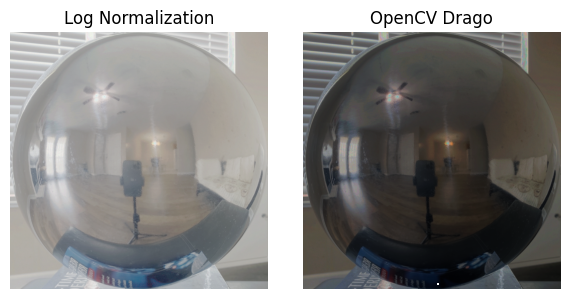

array([[[0.3344069 , 0.3443128 , 0.36291304],
        [0.32309934, 0.32988206, 0.35846975],
        [0.3346489 , 0.35645443, 0.37190795],
        ...,
        [0.29319653, 0.25483462, 0.2295971 ],
        [0.28727517, 0.2529661 , 0.22943254],
        [0.28727517, 0.2529661 , 0.22943254]],

       [[0.33745402, 0.35663176, 0.371332  ],
        [0.3154641 , 0.3466799 , 0.3835704 ],
        [0.31129032, 0.34495848, 0.34753186],
        ...,
        [0.29354283, 0.2550214 , 0.20996653],
        [0.2875955 , 0.2531414 , 0.20973764],
        [0.2875955 , 0.2531414 , 0.20973764]],

       [[0.49271435, 0.5193796 , 0.5814291 ],
        [0.49896935, 0.4976173 , 0.5101355 ],
        [0.42607275, 0.4647705 , 0.5093311 ],
        ...,
        [0.3057198 , 0.25476268, 0.21874523],
        [0.30315885, 0.25598827, 0.23795916],
        [0.30315885, 0.25598827, 0.23795916]],

       ...,

       [[0.3854441 , 0.36976397, 0.39429814],
        [0.39086893, 0.39580902, 0.41469213],
        [0.3856704 , 0

In [14]:
lm = 5
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

print("HDR shape before saving:", calib_hdr_image.shape)
print("HDR value range:", calib_hdr_image.min(), calib_hdr_image.max())

# Make sure it has exactly 3 channels
assert len(calib_hdr_image.shape) == 3 and calib_hdr_image.shape[2] == 3, "HDR must be 3 channels"

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.45100445   Max ratio =  12.341247


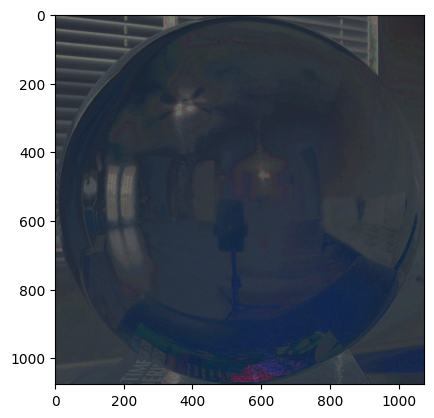

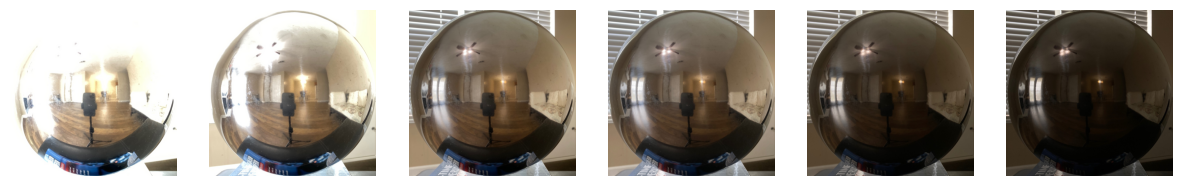

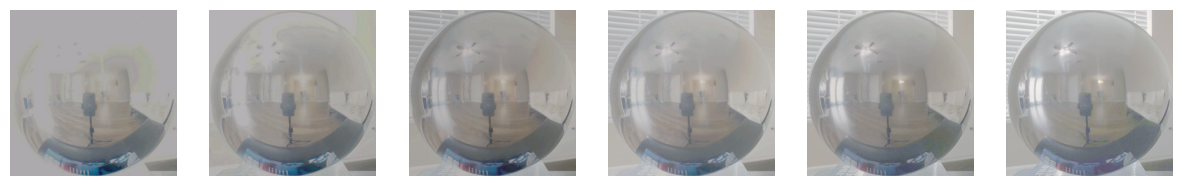

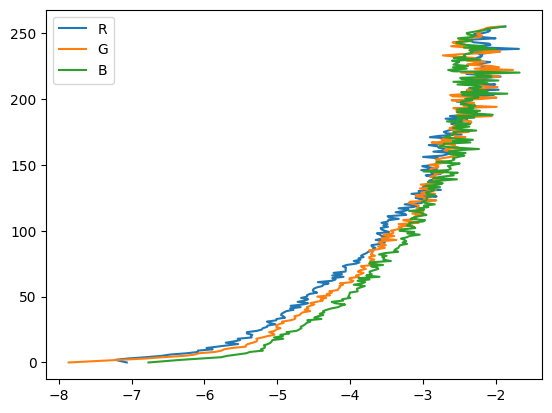

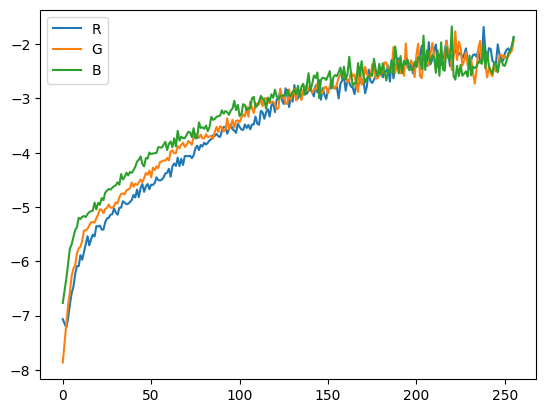

In [15]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  7.403 	avg RMS error =  0.335
weighted:	log range =  7.466 	avg RMS error =  0.312
calibrated:	log range =  7.622 	avg RMS error =  0.264


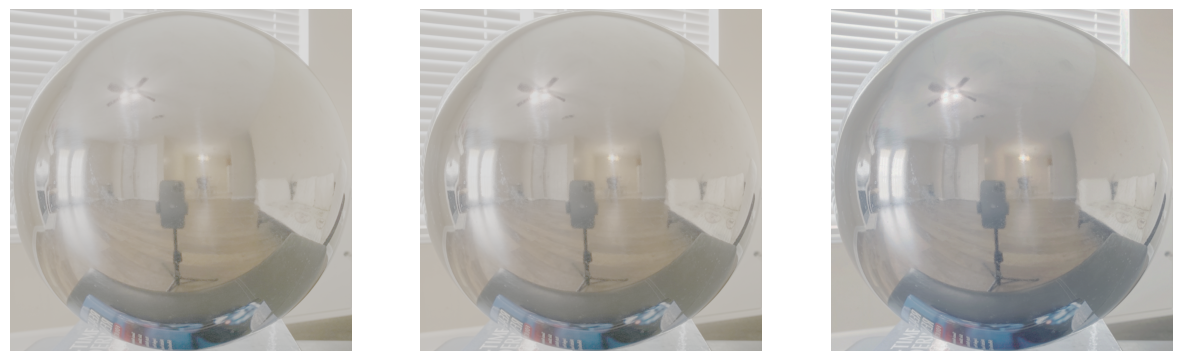

In [16]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations

Compute the equirectangular image from the mirrorball image

In [17]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image,

    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.

    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.

    Steps 3 and 4 are implemented for you with get_equirectangular_image
    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # to make even
    if H % 2 != 0:
        hdr_image = cv2.resize(hdr_image, (H-1, W-1))
        H, W = H-1, W-1

    # X,Y (normalized)
    X_norm, Y_norm, valid_mask = get_normalized_ball_coords(H, W, margin=5)

    # Z
    Z_norm = np.zeros_like(X_norm)
    R_sq = X_norm**2 + Y_norm**2
    Z_norm[valid_mask] = np.sqrt(1.0 - R_sq[valid_mask])

    # N = [X,Y,Z]
    N = np.stack([X_norm, Y_norm, Z_norm], axis=2).astype(np.float32)

    # R
    R = np.zeros_like(N)

    # using the OpenGL coordinate system, where the camera looks along the -Z axis
    # V = [0, 0, -1]
    V = np.zeros_like(N)
    V[:, :, 2] = -1.0

    # R = V - 2(N·V)N
    # N·V = -N[:,:,2]
    NV = -N[:, :, 2] # N.[0,0,-1] => -N[,,2]
    R = V - 2 * NV[:, :, np.newaxis] * N

    # need R vectors only for the pixels inside the circle
    R = np.where(np.expand_dims(valid_mask, axis=2), R, 0)

    # finally
    equirectangular_image = get_equirectangular_image(R, hdr_image)

    # Visualize normal and reflection vectors
    plt.figure(figsize=(10, 4))

    # 'N' visualization ([-1,1] -> [0,1])
    plt.subplot(1, 3, 1)
    N_vis = (N + 1.0) / 2.0
    N_vis[~valid_mask] = 0
    plt.imshow(N_vis)
    plt.title('Normal Vectors')

    # 'R' visualization
    plt.subplot(1, 3, 2)
    R_vis = (R + 1.0) / 2.0
    R_vis[~valid_mask] = 0
    plt.imshow(R_vis)
    plt.title('Reflection Vectors')

    # HDR image
    plt.subplot(1, 3, 3)
    log_hdr = np.log(hdr_image + EPSILON)
    log_m, log_M = log_hdr.min(), log_hdr.max()
    log_normalized = (log_hdr - log_m) / (log_M - log_m)
    plt.imshow(log_normalized)
    plt.title('HDR Mirror Ball')

    plt.tight_layout()
    plt.show()

    return equirectangular_image



### Photographer/tripod removal


In [18]:
def remove_tripod_with_manual_grabcut(hdr_image):
    """
    Removes tripod/phone from HDR mirror ball using GrabCut with a manually defined bounding box.
    """
    H, W, C = hdr_image.shape

    # 1. [0,1] -> [0,255] for GrabCut
    log_img = np.log(hdr_image + EPSILON)
    log_m, log_M = log_img.min(), log_img.max()
    img_normed = (log_img - log_m) / (log_M - log_m)
    img_255 = (img_normed * 255).astype(np.uint8)

    # 2. bounding box
    #  (hint area)
    bb_x1 = 458
    bb_y1 = 537

    bb_x2 = 560
    bb_y2 = 875

    # GrabCut format (x,y,w,h)
    rect = (bb_x1, bb_y1, bb_x2 - bb_x1, bb_y2 - bb_y1)

    # Show the selected rectangle
    plt.figure(figsize=(8, 8))
    plt.imshow(img_normed)
    plt.gca().add_patch(plt.Rectangle((bb_x1, bb_y1), bb_x2 - bb_x1, bb_y2 - bb_y1,
                                      fill=False, edgecolor='red', linewidth=2))
    plt.title("Selected Rectangle for GrabCut")
    plt.axis('off')
    plt.show()

    # mask for GrabCut
    grabcut_mask = np.zeros((H, W), dtype=np.uint8)
    grabcut_mask[:,:] = cv2.GC_BGD
    grabcut_mask[bb_y1:bb_y2, bb_x1:bb_x2] = cv2.GC_PR_FGD # photographer bounding box

    # models for GrabCut
    bgd_model = np.zeros((1, 65), dtype=np.float64)
    fgd_model = np.zeros((1, 65), dtype=np.float64)

    print("Running GrabCut to segment the tripod/phone...")
    cv2.grabCut(img_255, grabcut_mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create mask where foreground pixels are set to 255
    #                   Definitely Foreground             Probably Foreground
    mask = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 255, 0).astype(np.uint8)

    plt.figure(figsize=(6, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_normed)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Detected Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # gonna inpaint each channel separately
    hdr_inpainted = np.zeros_like(hdr_image)

    print("Applying inpainting to each channel...")
    # for each R,G, and B
    for color in range(C):
        # Extract channel and convert to 8-bit for inpainting
        # [0,1] -> [0,255]
        hdr_temp = hdr_image[:,:,color]
        hdr_temp_m, hdr_temp_M = hdr_temp.min(), hdr_temp.max()
        hdr_temp_255 = np.clip((hdr_temp - hdr_temp_m) / (hdr_temp_M - hdr_temp_m) * 255, 0, 255).astype(np.uint8)

        # inpaint
        hdr_inpainted_255 = cv2.inpaint(hdr_temp_255, mask, inpaintRadius=20, flags=cv2.INPAINT_TELEA)

        # convert back to original HDR range
        hdr_inpainted_float = hdr_inpainted_255.astype(np.float32) / 255.0
        hdr_inpainted_temp = hdr_inpainted_float * (hdr_temp_M - hdr_temp_m) + hdr_temp_m
                                                #      updated      , no changes
        hdr_inpainted[:,:,color] = np.where(mask > 0, hdr_inpainted_temp, hdr_temp)


    plt.figure(figsize=(6, 4))

    # before
    plt.subplot(1, 2, 1)
    plt.imshow(img_normed)
    plt.title("Before Inpainting")
    plt.axis('off')

    # after
    plt.subplot(1, 2, 2)
    log_after = np.log(hdr_inpainted + EPSILON)
    norm_after = (log_after - log_m) / (log_M - log_m)
    plt.imshow(norm_after)
    plt.title("After Inpainting")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return hdr_inpainted

Starting tripod removal with manual bounding box...
You can adjust the rectangle coordinates in the code.


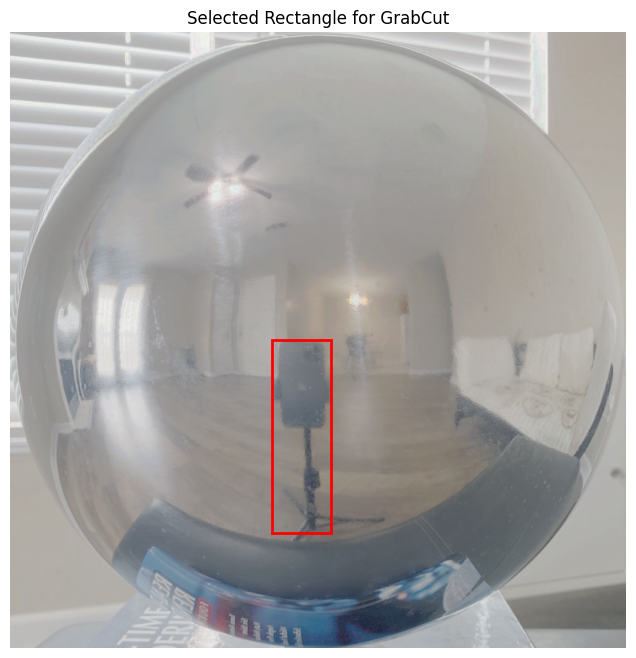

Running GrabCut to segment the tripod/phone...


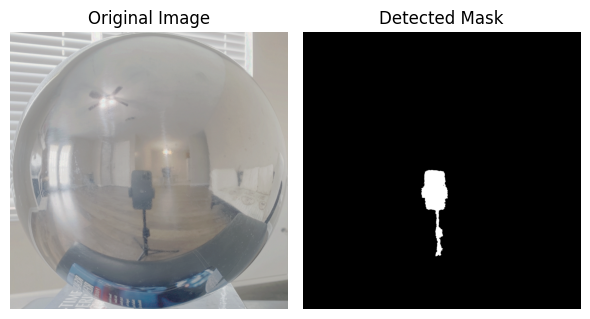

Applying inpainting to each channel...


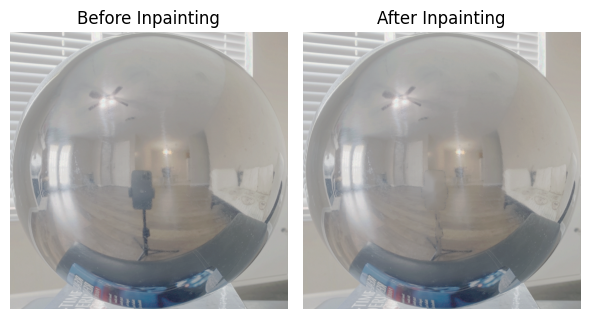

Inpainting complete!


In [19]:
# Run the GrabCut tripod removal function with manual bounding box
print("Starting tripod removal with manual bounding box...")
print("You can adjust the rectangle coordinates in the code.")
inpainted_hdr_image = remove_tripod_with_manual_grabcut(calib_hdr_image)

# Save the inpainted HDR image
write_hdr_image(inpainted_hdr_image, 'images/outputs/inpainted_hdr_image.hdr')

print("Inpainting complete!")

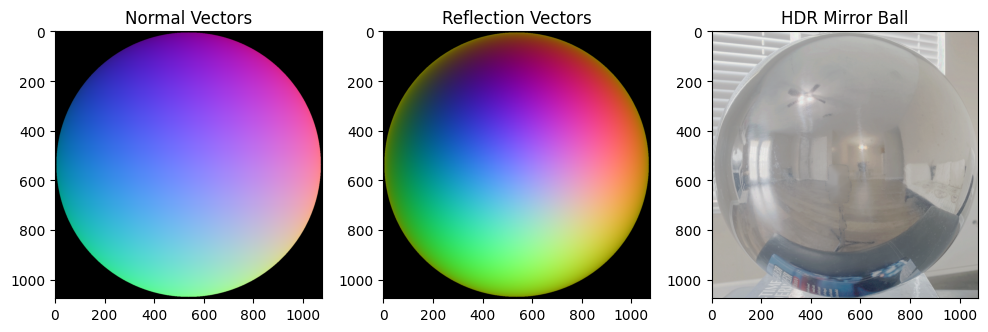

<Figure size 1000x1000 with 0 Axes>

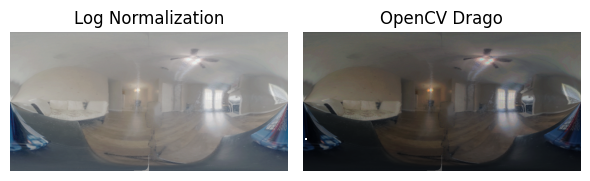

array([[[0.3020083 , 0.3020083 , 0.3020083 ],
        [0.3020083 , 0.3020083 , 0.3020083 ],
        [0.3020083 , 0.3020083 , 0.3020083 ],
        ...,
        [0.3020083 , 0.3020083 , 0.3020083 ],
        [0.3020083 , 0.3020083 , 0.3020083 ],
        [0.3020083 , 0.3020083 , 0.3020083 ]],

       [[0.3208185 , 0.34152088, 0.33158743],
        [0.33516943, 0.34291422, 0.33457062],
        [0.3428306 , 0.35124367, 0.34279627],
        ...,
        [0.34039629, 0.3459679 , 0.34213945],
        [0.3406626 , 0.34780627, 0.3450537 ],
        [0.3343083 , 0.3431479 , 0.33518714]],

       [[0.32908088, 0.3400517 , 0.34775728],
        [0.32282257, 0.34675717, 0.33887878],
        [0.3327061 , 0.34733889, 0.3325911 ],
        ...,
        [0.34074444, 0.34814665, 0.33674777],
        [0.335239  , 0.34441835, 0.3334984 ],
        [0.32410437, 0.3452922 , 0.33933368]],

       ...,

       [[0.06198965, 0.07665265, 0.08922649],
        [0.05908285, 0.07594689, 0.08959161],
        [0.05960176, 0

In [20]:
#hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
#eq_image = panoramic_transform(hdr_mirrorball_image)
eq_image = panoramic_transform(inpainted_hdr_image)
write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')


plt.figure(figsize=(10,10))
display_hdr_image(eq_image)


In [21]:
#!mkdir -p "{datadir}blender_assets"
#!cp images/outputs/equirectangular.hdr "{datadir}blender_assets/"

---

## Rendering synthetic objects into photographs

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [22]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects.png')
E = read_image('images/proj4_empty.png')
M = read_image('images/proj4_mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

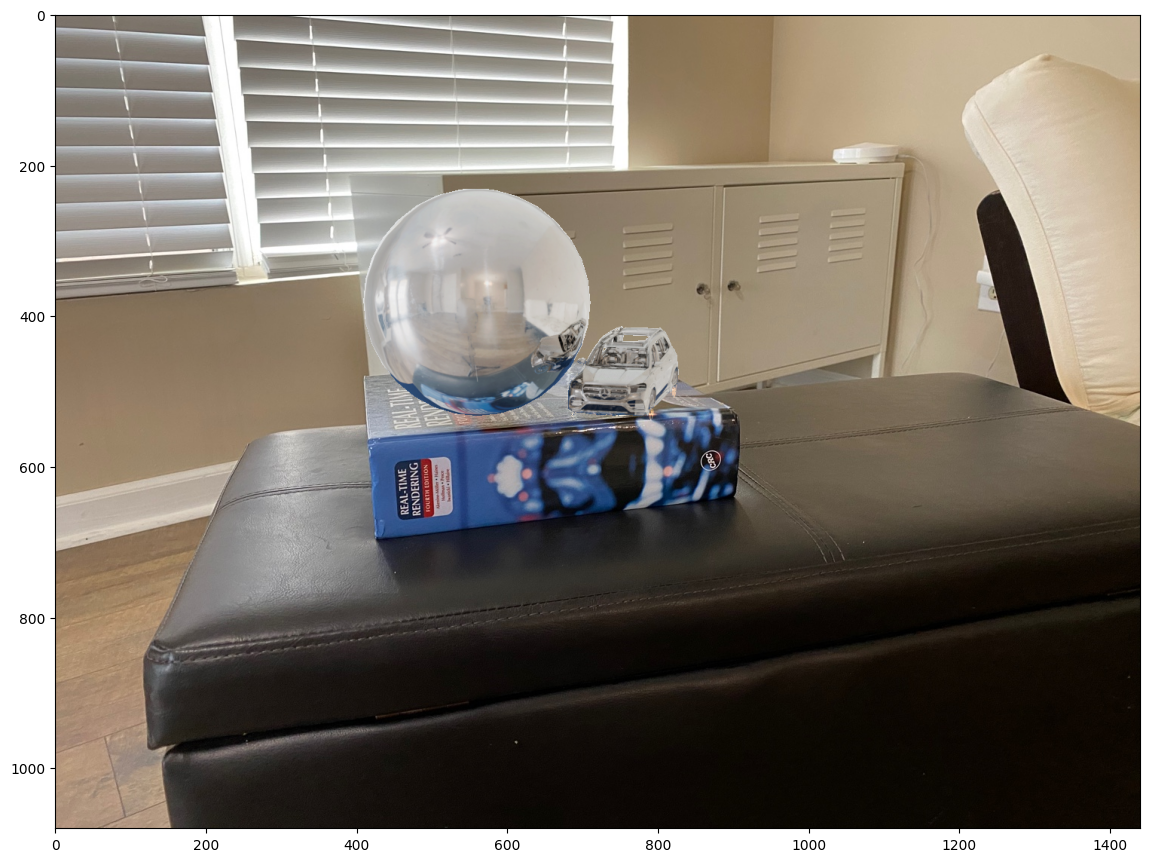

In [23]:
# TO DO: compute final composite
result = []

# Uscomposite = M*O + (1-M)*I + (1-M)*(O-E)*c

# lighting/shadow coefficient
c = 1.0

result = np.zeros_like(I)
lighting_effects = O - E

for color in range(3):  # For each color channel
    result[:, :, color] = (M[:, :, color] * O[:, :, color] + # objects
                       (1 - M[:, :, color]) * I[:, :, color] + # background
                       (1 - M[:, :, color]) * lighting_effects[:, :, color] * c) # lighting, shadow

result = np.clip(result, 0, 1)

plt.figure(figsize=(14,14))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

---


## Bells & Whistles (Extra Points)




### Additional Image-Based Lighting Result




### Other panoramic transformations


In [24]:
def mirror_ball_to_angular(hdr_image, margin=5):
    '''
    Converts mirror ball HDR to angular (fisheye) projection.
    added margin to prevent edges geting distorted
    '''
    print("Starting angular map conversion...")

    H, W, C = hdr_image.shape

    width = min(H, W)
    result = np.zeros((width, width, C), dtype=np.float32)

    cx, cy = W // 2, H // 2
    r = min(cx, cy) - margin

    y_out, x_out = np.meshgrid(np.arange(width), np.arange(width), indexing='ij')

    # normalize to unit length [-1,1]
    #   e.g., width=4, [0,1,2,3] -> [-1.0, ... , 1.0]
    x_norm = 2.0 * ((x_out / (width - 1)) - 0.5)
    y_norm = 2.0 * ((y_out / (width - 1)) - 0.5)
    r_norm = np.sqrt(x_norm**2 + y_norm**2)

    mask = r_norm <= 1.0

    # get spherical coordinates
    phi = np.arctan2(y_norm, x_norm)
    theta = r_norm * (np.pi / 2)
    mirror_r = np.sin(theta)

    mirror_x = cx + r * mirror_r * np.cos(phi)
    mirror_y = cy + r * mirror_r * np.sin(phi)

    # normalized -> convert back to INT (with bounds check)
    mirror_x = np.clip(np.round(mirror_x).astype(int), 0, W-1)
    mirror_y = np.clip(np.round(mirror_y).astype(int), 0, H-1)

    # Sample from mirror ball
    # (rectangular) hdr -> angular
    angular_map = np.where(mask[:, :, np.newaxis], hdr_image[mirror_y, mirror_x], 0)


    print("Angular map conversion completed")
    return angular_map

In [25]:
def mirror_ball_to_vertical_cross(hdr_image, margin=5):
    '''
    Creates a vertical cross cubemap from mirror ball HDR.
    '''
    print("Starting vertical cross cubemap conversion...")

    H, W, C = hdr_image.shape

    # unfolding as a cube map enlarges the W,H.
    face_size = min(H, W) // 4

    cubemap = np.zeros((face_size*4, face_size*3, C), dtype=np.float32)

    cx, cy = W // 2, H // 2
    radius = min(cx, cy) - margin

    # wenth with OpenGL convention
    faces = [
        (face_size, 2*face_size,  (1,  0, 0)), # +X (right)
        (face_size, 0,            (-1, 0, 0)), # -X (left)
        (0, face_size,            (0,  1, 0)), # +Y (top)
        (2*face_size, face_size , (0, -1, 0)), # -Y (bottom)
        (face_size, face_size   , (0,  0, 1)), # +Z (front)
        (3*face_size, face_size , (0,  0, -1)) # -Z (back)
    ]

    # for each face
    for face_idx, (y_offset, x_offset, (face_x, face_y, face_z)) in enumerate(faces):
        print(f"Processing face {face_idx+1}/6...")

        y_face, x_face = np.meshgrid(np.arange(face_size), np.arange(face_size), indexing='ij')


        u = 2.0 * (x_face / (face_size - 1) - 0.5)
        v = 2.0 * (y_face / (face_size - 1) - 0.5)

        if face_x == 1:  # +X face
            dir_x = np.ones_like(u)
            dir_y = -v
            dir_z = -u
        elif face_x == -1:  # -X
            dir_x = -np.ones_like(u)
            dir_y = -v
            dir_z = u
        elif face_y == 1:  # +Y
            dir_x = u
            dir_y = np.ones_like(u)
            dir_z = v
        elif face_y == -1:  # -Y
            dir_x = u
            dir_y = -np.ones_like(u)
            dir_z = -v
        elif face_z == 1:  # +Z
            dir_x = u
            dir_y = -v
            dir_z = np.ones_like(u)
        elif face_z == -1:  # -Z
            dir_x = -u
            dir_y = -v
            dir_z = -np.ones_like(u)

        norm = np.sqrt(dir_x**2 + dir_y**2 + dir_z**2)
        dir_x /= norm
        dir_y /= norm
        dir_z /= norm

        # to spherical coordinates (for mirror ball lookup)
        theta = np.arccos(np.clip(dir_z, -1.0, 1.0))
        phi = np.arctan2(dir_y, dir_x)

        # Mirror ball coordinates
        # The radius in the mirror ball is proportional to sin(theta)
        mirror_r = np.sin(theta)

        # Convert to pixel coordinates in the mirror ball
        mirror_x = cx + radius * mirror_r * np.cos(phi)
        mirror_x = np.clip(np.round(mirror_x).astype(int), 0, W-1)

        mirror_y = cy + radius * mirror_r * np.sin(phi)
        mirror_y = np.clip(np.round(mirror_y).astype(int), 0, H-1)


        cubemap[y_offset:y_offset+face_size, x_offset:x_offset+face_size, :] = hdr_image[mirror_y, mirror_x,:]


    print("Vertical cross cubemap conversion complete")
    return cubemap


---- CREATING PANORAMIC TRANSFORMATIONS ----

Starting angular map conversion...
Angular map conversion completed
Starting vertical cross cubemap conversion...
Processing face 1/6...
Processing face 2/6...
Processing face 3/6...
Processing face 4/6...
Processing face 5/6...
Processing face 6/6...
Vertical cross cubemap conversion complete

---- VISUALIZING RESULTS ----



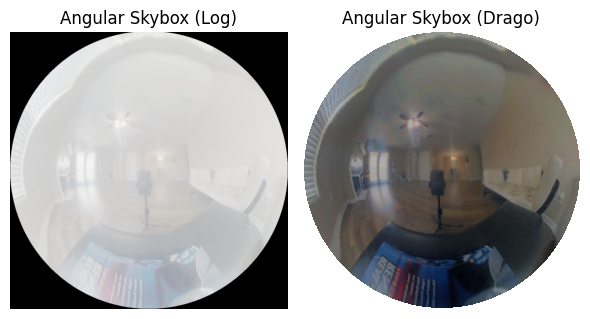

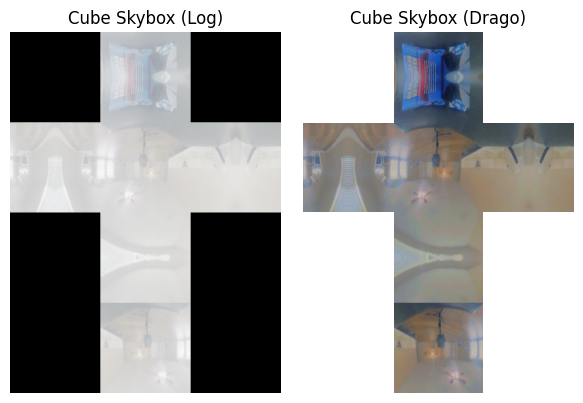

- images/outputs/angular_map.hdr
- images/outputs/cubemap.hdr


In [26]:
print("\n---- CREATING PANORAMIC TRANSFORMATIONS ----\n")

# create angular map
angular_map = mirror_ball_to_angular(calib_hdr_image)
write_hdr_image(angular_map, 'images/outputs/angular_map.hdr')

# create vertical cross cubemap
cubemap = mirror_ball_to_vertical_cross(calib_hdr_image)
write_hdr_image(cubemap, 'images/outputs/cubemap.hdr')


print("\n---- VISUALIZING RESULTS ----\n")
# 1. angular map visualization
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
#    (1) log normalization
log_am = np.log(angular_map + EPSILON)
log_m, log_M = log_am.min(), log_am.max()
log_norm_am = (log_am - log_m) / (log_M - log_m)
plt.imshow(log_norm_am)
plt.title("Angular Skybox (Log)")
plt.axis('off')

plt.subplot(1, 2, 2)
#    (2) drago tonemapping
am_copy = angular_map.copy().astype(np.float32)
am_copy = np.nan_to_num(am_copy, nan=0, posinf=np.finfo(np.float32).max, neginf=0)
tonemapper = cv2.createTonemapDrago(gamma=1.0, saturation=0.7)
tonemapped_am = tonemapper.process(am_copy)
plt.imshow(tonemapped_am)
plt.title("Angular Skybox (Drago)")
plt.axis('off')
plt.tight_layout()
plt.show()

# 2. cubemap visualization
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
#    (1) Log normalization
log_cm = np.log(cubemap + EPSILON)
log_m, log_M = log_cm.min(), log_cm.max()
log_norm_cm = (log_cm - log_m) / (log_M - log_m)
plt.imshow(log_norm_cm)
plt.title("Cube Skybox (Log)")
plt.axis('off')

plt.subplot(1, 2, 2)
#    (2) drago tonemapping
cm_copy = cubemap.copy().astype(np.float32)
cm_copy = np.nan_to_num(cm_copy, nan=0, posinf=np.finfo(np.float32).max, neginf=0)
tonemapper = cv2.createTonemapDrago(gamma=1.0, saturation=0.7)
tonemapped_cm = tonemapper.process(cm_copy)
plt.imshow(tonemapped_cm)
plt.title("Cube Skybox (Drago)")
plt.axis('off')
plt.tight_layout()
plt.show()

print("- images/outputs/angular_map.hdr")
print("- images/outputs/cubemap.hdr")


### Local tonemapping operator

In [27]:
def local_tonemapping_durand(hdr_image, sigma_spatial=8.0, sigma_range=0.4, compression_factor=0.5):
    """
    Durand and Dorsey's local tone mapping (bilateral filtering)
    """
    print("Implementing Durand & Dorsey local tone mapping (bilateral filtering)...")

    # for compatibility
    if not hasattr(np, 'int'):
        np.int = int

    log_hdr = np.log10(hdr_image + EPSILON)
    result = np.zeros_like(hdr_image)

    for color in range(3):

        channel = log_hdr[:,:,color]

        edge_m = np.min(channel)
        edge_M = np.max(channel)

        # global
        base = bilateral_filter(
            data=channel,
            edge=channel,
            edge_min=edge_m,
            edge_max=edge_M,
            sigma_spatial=sigma_spatial,
            sigma_range=sigma_range
        )
        compressed_base = base * compression_factor

        # local
        detail = channel - base

        # reconstruct, keeping details
        log_result = compressed_base + detail

        # back to non log
        result[:,:,color] = np.power(10, log_result)

    # normalize
    valid_mask = np.isfinite(result)
    if np.any(valid_mask):
        m = np.min(result[valid_mask])
        M = np.max(result[valid_mask])
        result = np.clip((result - m) / (M - m), 0, 1)

    result = np.nan_to_num(result, nan=0.0, posinf=1.0, neginf=0.0)

    return result

In [28]:

def apply_global_tonemapping(hdr_image, method='reinhard'):
    """
    method: 'reinhard', 'gamma', 'log', or 'drago'
    """
    # Handle any NaN or inf values
    img = np.nan_to_num(hdr_image.copy(), nan=0.0, posinf=100.0, neginf=0.0)

    if method == 'reinhard':
        result = img / (1.0 + img)

    elif method == 'gamma':
        # normalize
        max_val = np.max(img)
        normalized = img / max_val

        result = np.power(normalized, 1/2.2)

    elif method == 'log':
        log_img = np.log(img + 1.0)
        # normalize
        log_m, log_M = np.min(log_img), np.max(log_img)

        result = (log_img - log_m) / (log_M - log_m)

    elif method == 'drago':
        hdr_float32 = img.astype(np.float32)
        tonemapper = cv2.createTonemapDrago(gamma=1.0, saturation=0.7)
        result = tonemapper.process(hdr_float32)

    else:
        raise ValueError(f"Unknown tonemapping method: {method}")

    return result

In [29]:
def compare_tonemapping_methods(hdr_image):
    """
    Compares different tonemapping methods including Durand's bilateral filtering approach.
    """
    print("Comparing tonemapping methods!")

    # global tonemapping methods---------------------------
    print("Applying Drago tonemapping...")
    drago_result = apply_global_tonemapping(hdr_image, 'drago')

    print("Applying Reinhard tonemapping...")
    reinhard_result = apply_global_tonemapping(hdr_image, 'reinhard')

    print("Applying Gamma correction...")
    gamma_result = apply_global_tonemapping(hdr_image, 'gamma')

    print("Applying Log mapping...")
    log_result = apply_global_tonemapping(hdr_image, 'log')
    # ------------------------------------------------------------
    print("Applying local tonemapping (Durand & Dorsey)...")
    try:
        # resize small for faster bilateral operation
        small_hdr = cv2.resize(hdr_image, (hdr_image.shape[1]//4, hdr_image.shape[0]//4))
        local_default_small = local_tonemapping_durand(small_hdr, sigma_spatial=8.0, sigma_range=0.4, compression_factor=0.5)
        local_strong_small = local_tonemapping_durand(small_hdr, sigma_spatial=16.0, sigma_range=0.4, compression_factor=0.3)

        # resize back to original size
        local_default = cv2.resize(local_default_small, (hdr_image.shape[1], hdr_image.shape[0]))
        local_strong = cv2.resize(local_strong_small, (hdr_image.shape[1], hdr_image.shape[0]))
    except Exception as e:
        print(f"Error with bilateral filter: {e}")
        raise

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 3, 1)
    plt.imshow(np.clip(drago_result, 0, 1))
    plt.title('Drago (Global)')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(np.clip(reinhard_result, 0, 1))
    plt.title('Reinhard (Global)')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(np.clip(gamma_result, 0, 1))
    plt.title('Gamma Correction (Global)')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(np.clip(log_result, 0, 1))
    plt.title('Logarithmic (Global)')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(np.clip(local_default, 0, 1))
    plt.title('Durand Bilateral (Default)')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(np.clip(local_strong, 0, 1))
    plt.title('Durand Bilateral (Strong)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.imsave('images/outputs/tonemapped_drago.png', np.clip(drago_result, 0, 1))
    plt.imsave('images/outputs/tonemapped_reinhard.png', np.clip(reinhard_result, 0, 1))
    plt.imsave('images/outputs/tonemapped_gamma.png', np.clip(gamma_result, 0, 1))
    plt.imsave('images/outputs/tonemapped_log.png', np.clip(log_result, 0, 1))
    plt.imsave('images/outputs/tonemapped_durand_default.png', np.clip(local_default, 0, 1))
    plt.imsave('images/outputs/tonemapped_durand_strong.png', np.clip(local_strong, 0, 1))

    return {
        'drago': drago_result,
        'reinhard': reinhard_result,
        'gamma': gamma_result,
        'log': log_result,
        'durand_default': local_default,
        'durand_strong': local_strong
    }

Comparing tonemapping methods!
Applying Drago tonemapping...
Applying Reinhard tonemapping...
Applying Gamma correction...
Applying Log mapping...
Applying local tonemapping (Durand & Dorsey)...
Implementing Durand & Dorsey local tone mapping (bilateral filtering)...
Implementing Durand & Dorsey local tone mapping (bilateral filtering)...


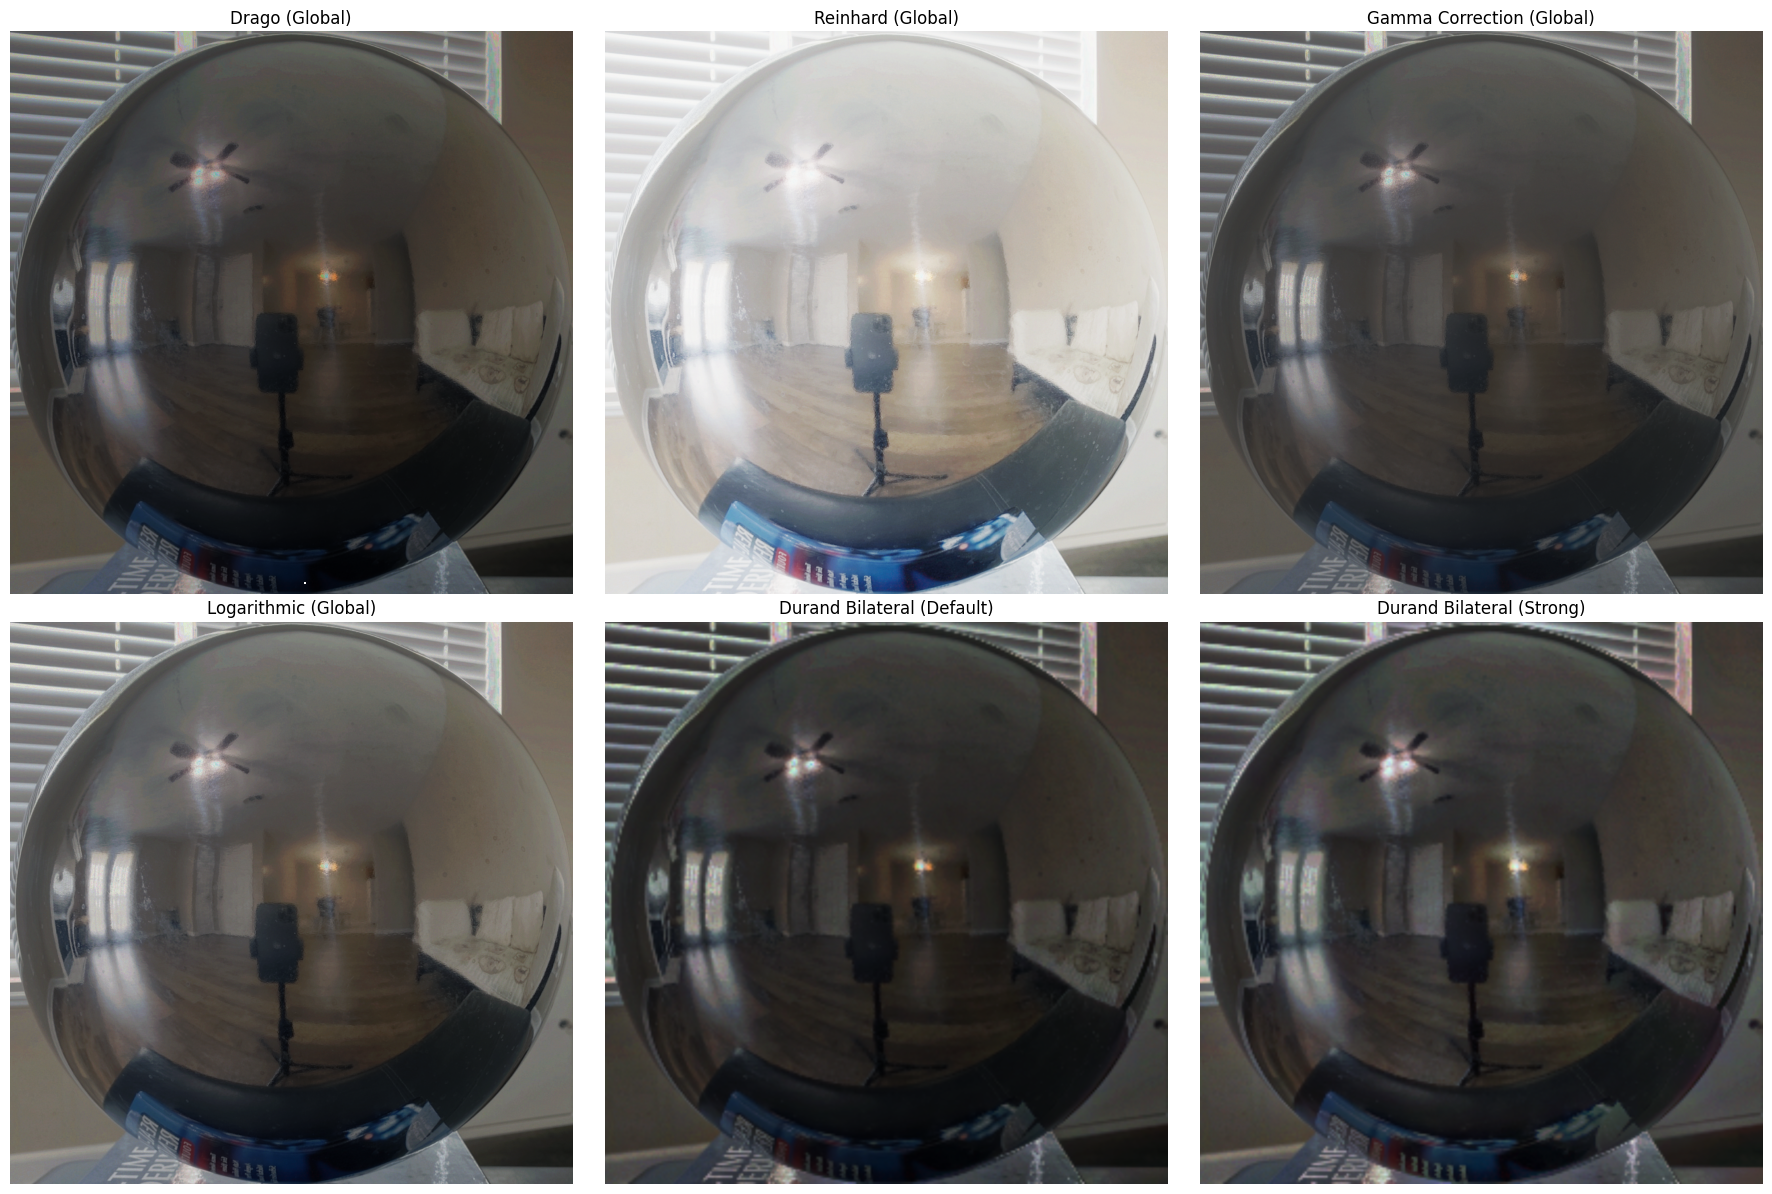

In [30]:
# run
tonemapped_results = compare_tonemapping_methods(calib_hdr_image)
